In [49]:
%cd supervised
%load_ext autoreload
%autoreload 2

import dill
import data
import train
import evaluate
import models
import torch

[Errno 2] No such file or directory: 'supervised'
/home/maarten/Documents/masterthesis/supervised
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
dill.load_session('notebook_env.db')

# Dataset analysis

In [4]:
import glob
from lxml import etree

positives = []
negatives = []
for path in glob.glob('../training_data/*.xml'):
    with open(path, 'r') as f:
        xml = etree.fromstring(f.read().encode('utf-8'))
    pos = len(xml.xpath('/pdf2xml/page/text[@is-speech="true"]'))
    neg = len(xml.xpath('/pdf2xml/page/text[@is-speech="false"]'))
    positives.append(pos)
    negatives.append(neg)

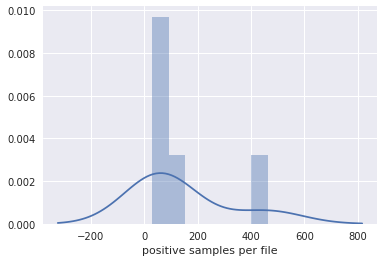

----------------  -----
Positive samples    705
Negative samples  35069
----------------  -----


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

sns.distplot(positives, axlabel='positive samples per file')
fig = plt.gcf()
plt.show()
fig.savefig('distribution.pdf')

print(tabulate([['Positive samples', sum(positives)],
                ['Negative samples', sum(negatives)]]))

# Training and evaluation

In [40]:
num_clusters = 5
window_size = 11
window_label = 6

files = [f'../clustered-{num_clusters}/18{i:03d}.xml' for i in [1, 2, 3, 4, 5]]

full_window_dataset = data.GermanDataset(files, num_clusters, 1.0, window_size, window_label,
                                        cluster_fmt=data.ClusterFmt.FULL_WINDOW)
only_center_dataset = data.GermanDataset(files, num_clusters, 1.0, window_size, window_label,
                                        cluster_fmt=data.ClusterFmt.ONLY_CENTRAL)
only_idx_dataset = data.GermanDataset(files, num_clusters, 1.0, window_size, window_label,
                                        cluster_fmt=data.ClusterFmt.FULL_WINDOW_ONLY_IDX)

Creating dictionary:  40%|████      | 2/5 [00:00<00:00, 17.26it/s]

Retrieved 695 positive samples, 33907 negative samples.


Creating dictionary:  40%|████      | 2/5 [00:00<00:00, 17.19it/s]

Retrieved 695 positive samples, 33907 negative samples.


Creating dictionary: 100%|██████████| 5/5 [00:00<00:00,  8.07it/s]


Retrieved 695 positive samples, 33907 negative samples.


# Test the different kinds of cluster handling
# 1000 samples

In [44]:
params = train.CNNParams(
    embed_size=300,
    dropout=0.3,
    epochs=100,
    filters=[(33, 3), (34, 5), (33, 7)],
    num_layers=1
)

optim_fn = lambda p: torch.optim.Adadelta(p, weight_decay=1e-4)

no_labels = evaluate.cross_val(10, 800, 
                               lambda r: models.NoClusterLabels(r, params.dropout),
                               optim_fn, only_idx_dataset, params)
only_center = evaluate.cross_val(10, 800,
                                 lambda r: models.CategoricalClusterLabelsOnlyCenter(r, num_clusters, params.dropout),
                                 optim_fn, only_center_dataset, params)
full_window = evaluate.cross_val(10, 800,
                                 lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout),
                                 optim_fn, full_window_dataset, params)
with_cnn = evaluate.cross_val(10, 800,
                              lambda r: models.ClusterLabelsCNN(r, num_clusters, params.dropout),
                              optim_fn, only_idx_dataset, params)

100%|██████████| 10/10 [01:24<00:00,  8.44s/it]


Average convergence speed


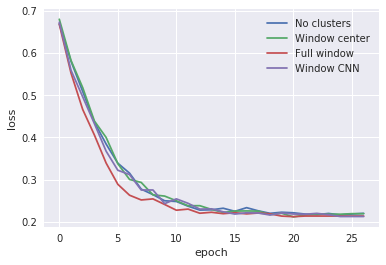


Average P/R curve


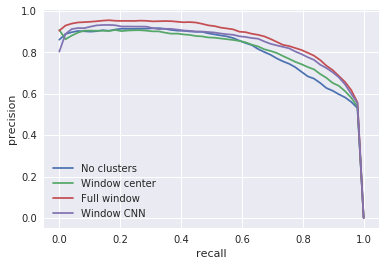


Score table:
model            F1 mean    F1 stddev    AoC mean    AoC std    Area under averaged curve
-------------  ---------  -----------  ----------  ---------  ---------------------------
No clusters     0.762332   0.0151038     0.748954  0.014515                      0.814618
Window center   0.783569   0.0111505     0.755135  0.0127125                     0.818773
Full window     0.82046    0.00554701    0.791899  0.0122418                     0.871375
Window CNN      0.810462   0.0120246     0.773475  0.0158784                     0.846052

AP plots:


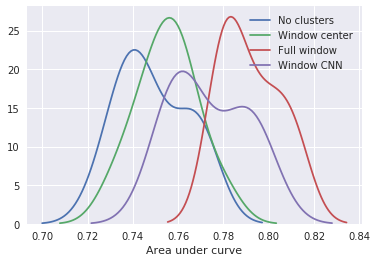

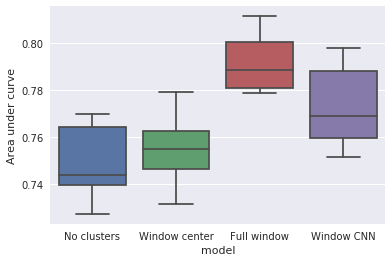

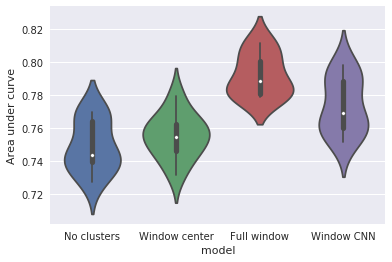


F1 plots:


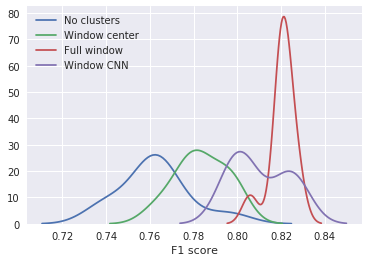

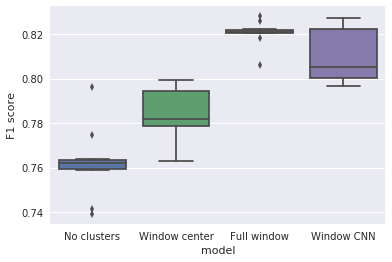

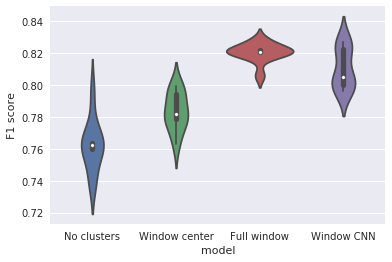


Statistical significance (dependent T-test):
F1 score
                 No clusters    Window center    Full window     Window CNN
-------------  -------------  ---------------  -------------  -------------
No clusters    nan                0.0193663      6.83171e-06    1.51942e-05
Window center    0.0193663      nan              9.04756e-06    0.000636625
Full window      6.83171e-06      9.04756e-06  nan              0.0356536
Window CNN       1.51942e-05      0.000636625    0.0356536    nan

Area under curve
                 No clusters    Window center    Full window    Window CNN
-------------  -------------  ---------------  -------------  ------------
No clusters    nan                0.276849       0.000335799     0.0143241
Window center    0.276849       nan              3.97012e-05     0.0360029
Full window      0.000335799      3.97012e-05  nan               0.0284781
Window CNN       0.0143241        0.0360029      0.0284781     nan


In [60]:
evaluate.analyze({'No clusters': no_labels,
                  'Window center': only_center,
                  'Full window': full_window,
                  'Window CNN': with_cnn},
                 'model', '../report/figures/results/models')

In [65]:
size_data = []
for n in [1, 2, 3, 5, 7, 9, 15, 30]:
    num_clusters = n
    window_size = 11
    window_label = 6

    files = [f'../clustered-{num_clusters}/18{i:03d}.xml' for i in [1, 2, 3, 4, 5]]

    full_window_dataset = data.GermanDataset(files, num_clusters, 1.0, window_size, window_label,
                                            cluster_fmt=data.ClusterFmt.FULL_WINDOW)

    params = train.CNNParams(
        embed_size=300,
        dropout=0.3,
        epochs=100,
        filters=[(33, 3), (34, 5), (33, 7)],
        num_layers=1
    )

    optim_fn = lambda p: torch.optim.Adadelta(p, weight_decay=1e-4)

    d = evaluate.cross_val(10, 800, lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout),
                           optim_fn, full_window_dataset, params)
    size_data.append(d)


  0%|          | 0/10 [00:00<?, ?it/s]

Retrieved 695 positive samples, 33907 negative samples.


100%|██████████| 10/10 [01:21<00:00,  8.15s/it]


Average convergence speed


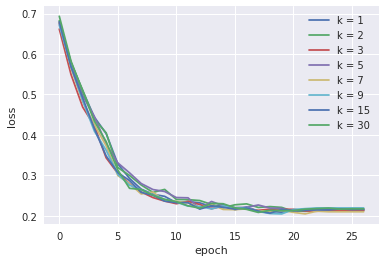


Average P/R curve


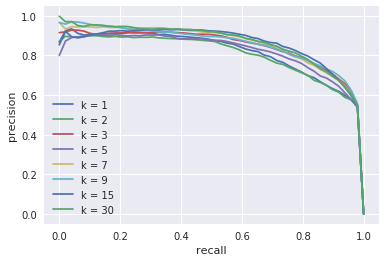


Score table:
k-means value      F1 mean    F1 stddev    AoC mean     AoC std    Area under averaged curve
---------------  ---------  -----------  ----------  ----------  ---------------------------
k = 1             0.765368    0.0114272    0.751865  0.0143037                      0.816884
k = 2             0.766783    0.0216771    0.745879  0.0156834                      0.804123
k = 3             0.806617    0.0063989    0.773238  0.00939995                     0.845716
k = 5             0.787416    0.0110071    0.756879  0.0104489                      0.820764
k = 7             0.802346    0.0121359    0.778122  0.00995233                     0.85781
k = 9             0.811269    0.0138173    0.779853  0.00918927                     0.856296
k = 15            0.8193      0.0135174    0.779117  0.0170232                      0.856548
k = 30            0.810528    0.0152773    0.779603  0.0144899                      0.863038

AP plots:


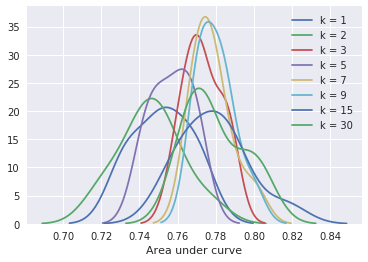

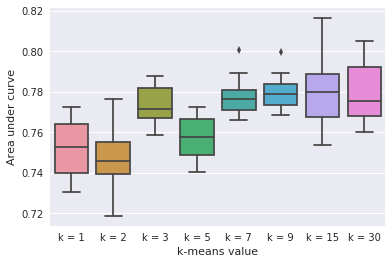

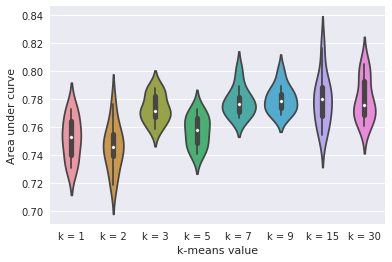


F1 plots:


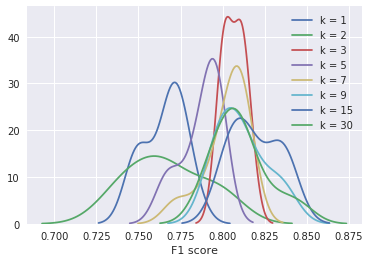

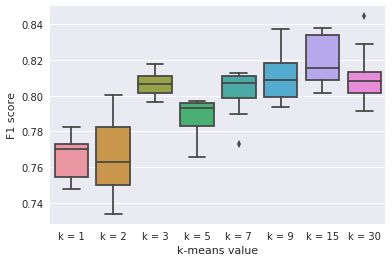

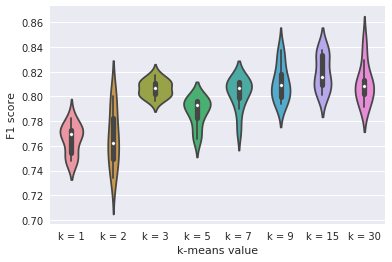


Statistical significance (dependent T-test):
F1 score
                k = 1          k = 2          k = 3          k = 5          k = 7          k = 9         k = 15         k = 30
------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
k = 1   nan              0.843475       6.67227e-06    0.00721606     5.67684e-05    5.13967e-05    8.81621e-06    1.48052e-05
k = 2     0.843475     nan              0.000523443    0.0236392      0.000976666    0.00222459     0.00020085     0.000137076
k = 3     6.67227e-06    0.000523443  nan              0.00120732     0.439836       0.353921       0.0672966      0.44784
k = 5     0.00721606     0.0236392      0.00120732   nan              0.00758928     0.00250627     0.000192284    0.00250277
k = 7     5.67684e-05    0.000976666    0.439836       0.00758928   nan              0.252954       0.00908183     0.166264
k = 9     5.13967e-05    0.00222459     0.353921       0.0025062

In [67]:
evaluate.analyze(dict(zip(['k = 1', 'k = 2', 'k = 3', 'k = 5', 'k = 7', 'k = 9', 'k = 15', 'k = 30'], size_data)),
                 'k-means value', '../report/figures/results/kmeans')

# Test regularization methods

In [18]:
params = train.CNNParams(
    embed_size=300,
    dropout=0.0,
    epochs=100,
    filters=[(33, 3), (34, 5), (33, 7)],
    num_layers=1
)

optim_no_decay = lambda p: torch.optim.Adadelta(p)

dropout_tests = []
dropout_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
for value in dropout_values:
    params.dropout = value
    dropout_tests.append(evaluate.cross_val(10, 800,
                                            lambda r: models.NoClusterLabels(r, params.dropout),
                                            optim_no_decay, only_idx_dataset, params))

100%|██████████| 10/10 [04:41<00:00, 28.14s/it]


Average convergence speed


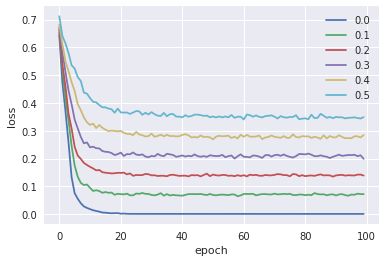


Average P/R curve


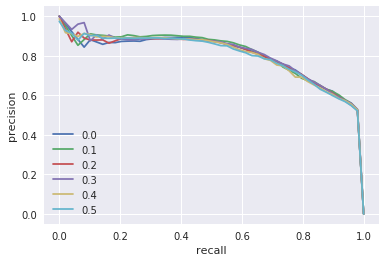


Score table:
  dropout rate    F1 mean    F1 stddev    AoC mean     AoC std    Area under averaged curve
--------------  ---------  -----------  ----------  ----------  ---------------------------
           0     0.76126     0.0133728    0.714461  0.0105124                      0.799083
           0.1   0.756681    0.0190385    0.714664  0.0120656                      0.809108
           0.2   0.761842    0.0115077    0.716461  0.010563                       0.801978
           0.3   0.765695    0.0101811    0.715871  0.00994032                     0.810398
           0.4   0.755077    0.0172803    0.716783  0.0105444                      0.801529
           0.5   0.756964    0.0130938    0.717907  0.0143531                      0.79936

AP plots:


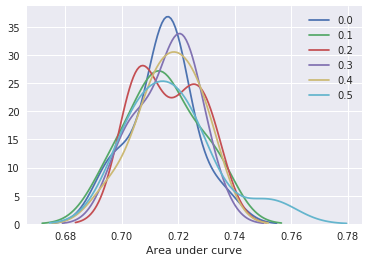

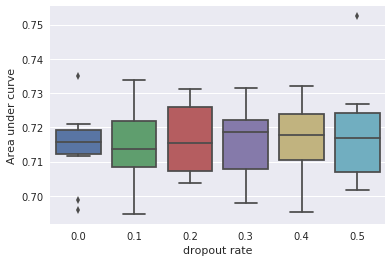

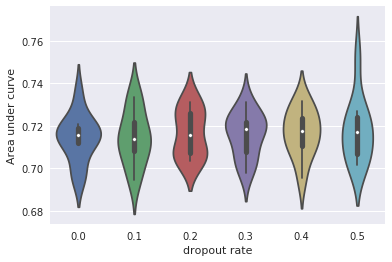


F1 plots:


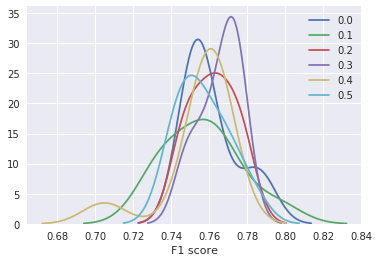

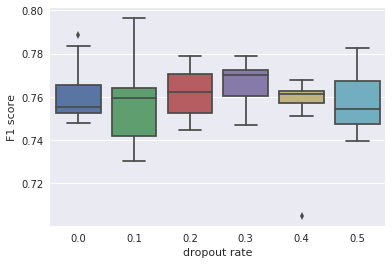

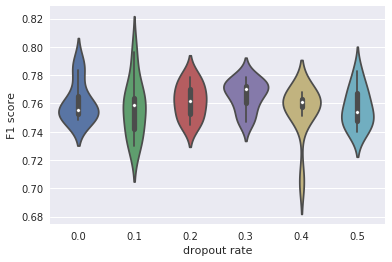


Statistical significance (dependent T-test):
F1 score
            0.0         0.1         0.2         0.3         0.4         0.5
---  ----------  ----------  ----------  ----------  ----------  ----------
0    nan           0.520569    0.935913    0.514088    0.404877    0.546787
0.1    0.520569  nan           0.488665    0.267547    0.816079    0.96717
0.2    0.935913    0.488665  nan           0.457223    0.434784    0.416762
0.3    0.514088    0.267547    0.457223  nan           0.16948     0.12529
0.4    0.404877    0.816079    0.434784    0.16948   nan           0.799983
0.5    0.546787    0.96717     0.416762    0.12529     0.799983  nan

Area under curve
            0.0         0.1         0.2         0.3         0.4         0.5
---  ----------  ----------  ----------  ----------  ----------  ----------
0    nan           0.963342    0.716821    0.809773    0.686929    0.642764
0.1    0.963342  nan           0.74443     0.826117    0.702059    0.570689
0.2    0.716821    0.744

In [57]:
evaluate.analyze(dict(zip(dropout_values, dropout_tests)), 'dropout rate', '../report/figures/results/dropout')

In [19]:
decay_tests = []
decay_values = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
for value in decay_values:
    params.dropout = 0.0
    optim_decay = lambda p: torch.optim.Adadelta(p, weight_decay=value)
    decay_tests.append(evaluate.cross_val(10, 800,
                                          lambda r: models.NoClusterLabels(r, params.dropout),
                                          optim_decay, only_idx_dataset, params))

100%|██████████| 10/10 [04:52<00:00, 29.27s/it]


Average convergence speed


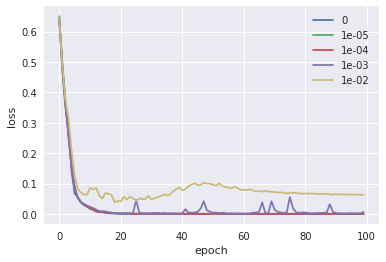


Average P/R curve


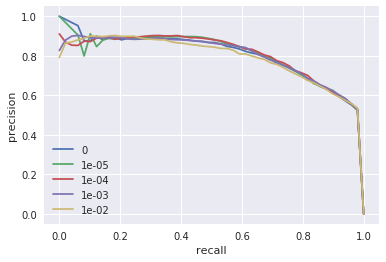


Score table:
  decay value    F1 mean    F1 stddev    AoC mean    AoC std    Area under averaged curve
-------------  ---------  -----------  ----------  ---------  ---------------------------
       0        0.759594    0.008119     0.710192  0.0078634                     0.805901
       1e-05    0.763445    0.0171368    0.715502  0.0113409                     0.807963
       0.0001   0.766299    0.0160939    0.732198  0.0102998                     0.80583
       0.001    0.762132    0.01537      0.736607  0.0131718                     0.801772
       0.01     0.753685    0.013023     0.737005  0.0150467                     0.791353

AP plots:


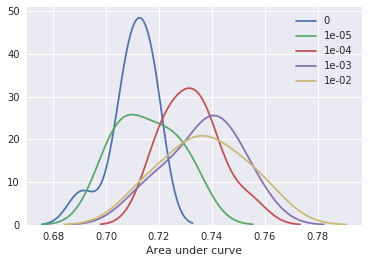

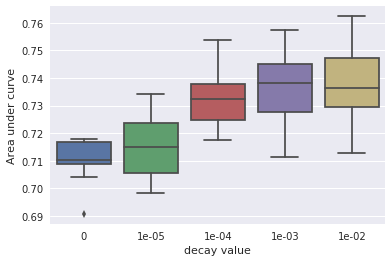

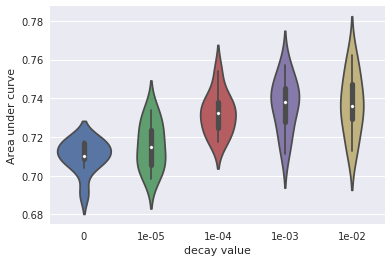


F1 plots:


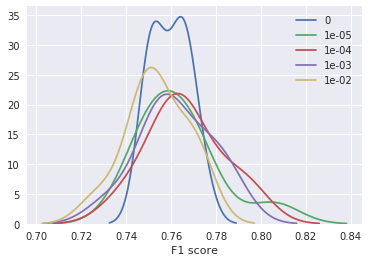

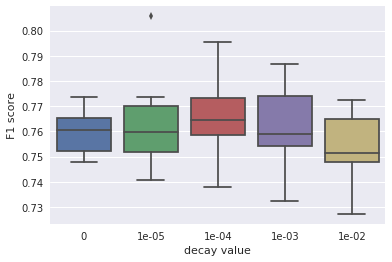

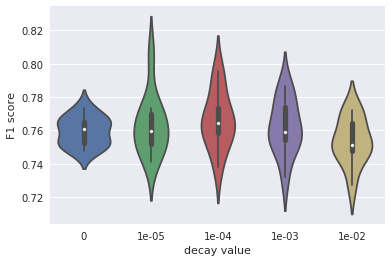


Statistical significance (dependent T-test):
F1 score
                 0       1e-05       1e-04       1e-03       1e-02
------  ----------  ----------  ----------  ----------  ----------
0       nan           0.617162    0.271349    0.625279    0.275793
1e-05     0.617162  nan           0.695672    0.865653    0.134641
0.0001    0.271349    0.695672  nan           0.627971    0.154331
0.001     0.625279    0.865653    0.627971  nan           0.140181
0.01      0.275793    0.134641    0.154331    0.140181  nan

Area under curve
                    0         1e-05          1e-04         1e-03         1e-02
------  -------------  ------------  -------------  ------------  ------------
0       nan              0.220064      0.000937274    0.00201767    0.00170547
1e-05     0.220064     nan             0.00727733     0.00502727    0.00471199
0.0001    0.000937274    0.00727733  nan              0.474782      0.522461
0.001     0.00201767     0.00502727    0.474782     nan             0.94

In [56]:
evaluate.analyze(dict(zip(map(lambda v: f'{v:.0e}' if v != 0 else 0, decay_values), decay_tests)),
                 'decay value', '../report/figures/results/decay')

In [36]:
params = train.CNNParams(
    embed_size=300,
    dropout=0.0,
    epochs=100,
    filters=[(33, 3), (34, 5), (33, 7)],
    num_layers=1
)

bn_tests = []
params.dropout = 0.0
optim_nodecay = lambda p: torch.optim.Adadelta(p)
bn_tests.append(evaluate.cross_val(10, 800,
                                   lambda r: models.NoClusterLabels(r, params.dropout, batch_norm=False),
                                   optim_nodecay, only_idx_dataset, params))
bn_tests.append(evaluate.cross_val(10, 800,
                                   lambda r: models.NoClusterLabels(r, params.dropout, batch_norm=True),
                                   optim_nodecay, only_idx_dataset, params))

100%|██████████| 10/10 [04:58<00:00, 29.83s/it]


Average convergence speed


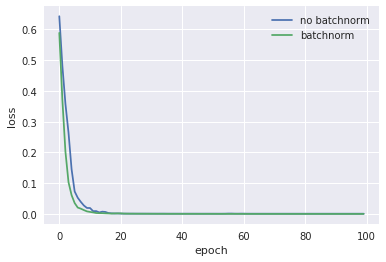


Average P/R curve


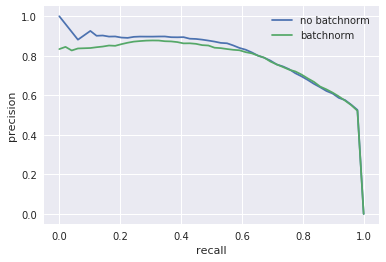


Score table:
variable        F1 mean    F1 stddev    AoC mean     AoC std    Area under averaged curve
------------  ---------  -----------  ----------  ----------  ---------------------------
no batchnorm   0.75511     0.0151998    0.71117   0.0126234                      0.805628
batchnorm      0.757993    0.0109182    0.724585  0.00929247                     0.782648

AP plots:


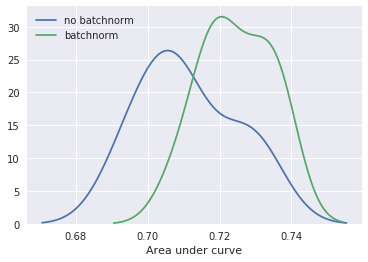

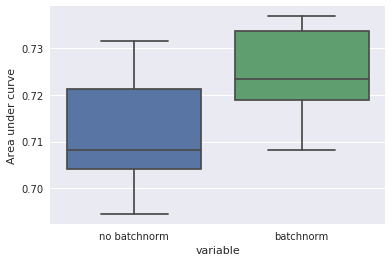

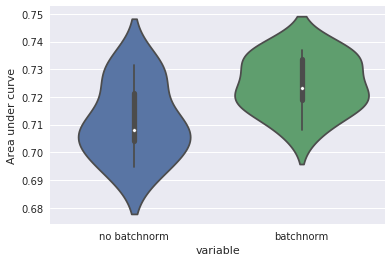


F1 plots:


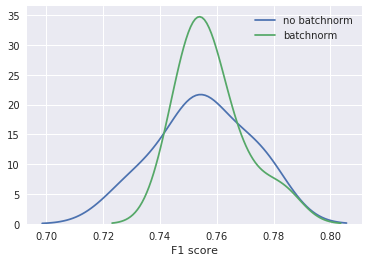

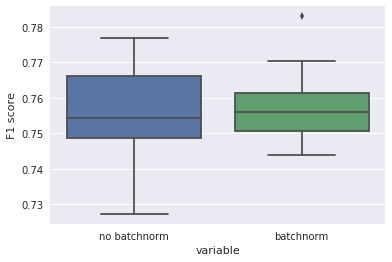

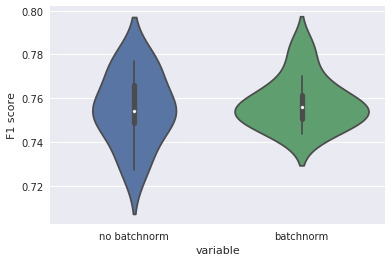


Statistical significance (dependent T-test):
F1 score
                no batchnorm    batchnorm
------------  --------------  -----------
no batchnorm      nan            0.657525
batchnorm           0.657525   nan

Area under curve
                no batchnorm    batchnorm
------------  --------------  -----------
no batchnorm     nan            0.0176731
batchnorm          0.0176731  nan


In [37]:
evaluate.analyze({'no batchnorm': bn_tests[0],
                  'batchnorm': bn_tests[1]})